In [2]:
# 기본적인 부분
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"]=False

# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 학습 알고리즘
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.special import expit, softmax

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier

In [744]:
seoul_sales=pd.read_csv("../data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
seoul_sales.shape

(87179, 55)

In [745]:
seoul_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


In [748]:
seoul_sales_copy=seoul_sales.copy()

In [750]:
seoul_restaurant_sales = seoul_sales_copy[seoul_sales_copy["서비스_업종_코드"].str.startswith("CS1")]
seoul_restaurant_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371
3,20241,U,관광특구,3001491,이태원 관광특구,CS100004,양식음식점,1.673468e+10,414722,8.256458e+09,...,135195,83964,228805,173511,3268,151680,156120,45901,31260,14074
4,20241,U,관광특구,3001491,이태원 관광특구,CS100005,제과점,1.255782e+09,96224,7.704259e+08,...,28562,8063,38105,54368,660,29740,28886,12736,12976,7472


In [752]:
seoul_street_people=pd.read_csv("../data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")
seoul_street_people.shape

(6595, 27)

In [754]:
seoul_street_people.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,2155176,1100997,1054179,140314,532219,...,320185,435781,276720,284230,272781,286789,286045,318414,368486,338431
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,335824,1194547,...,1706632,1327800,343472,1040403,1133875,1202348,1130314,1103850,706014,573054
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,3384560,1595828,1788732,188119,645950,...,524693,620807,401942,504854,524755,553766,540100,497858,381895,381333
3,20241,U,관광특구,3001494,종로?청계 관광특구,8440796,4496772,3944023,358062,1523184,...,1808704,1691285,660774,1258576,1328555,1410371,1345939,1334099,998247,765010
4,20241,U,관광특구,3001495,잠실 관광특구,4110178,1976808,2133370,434196,915211,...,653233,879474,477929,570999,570194,589977,580551,598178,621983,578294


In [776]:
seoul_working_people=pd.read_csv("../data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
seoul_working_people.shape

(6549, 26)

In [778]:
seoul_working_people.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553
3,20241,U,관광특구,3001494,종로?청계 관광특구,47296,26388,20908,670,9566,...,7326,7672,5302,1732,428,5452,6816,5204,2256,752
4,20241,U,관광특구,3001495,잠실 관광특구,111557,65817,45740,195,18343,...,18331,18070,13050,7197,115,9254,10943,10338,11338,3752


In [786]:
seoul_restaurant_sales["서비스_업종_코드_명"].unique()

array(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점',
       '분식전문점', '호프-간이주점', '커피-음료'], dtype=object)

In [762]:
seoul_restaurant_list = seoul_restaurant_sales["서비스_업종_코드_명"].unique()

results_with_working_population = {}

for restaurant in seoul_restaurant_list:
    temp_df = seoul_restaurant_sales[seoul_restaurant_sales["서비스_업종_코드_명"] == restaurant]
    
    # 평균매출
    mean_sales = temp_df.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액", "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
                                                            "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]].mean().reset_index()
    mean_sales.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)
    
    # 유동인구 데이터와 병합
    merged = pd.merge(mean_sales, seoul_street_people, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    # 직장인구 데이터와 병합
    merged_with_working = pd.merge(merged, seoul_working_people, on=["상권_코드_명", "기준_년분기_코드"], how="left")
    
    # 음식점별로 묶기 (한식음식점 데이터프레임, 중식음식점 데이터프레임, ... )
    results_with_working_population[restaurant] = merged_with_working

In [768]:
results_with_working_population

{'한식음식점':            상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
 0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
 1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
 2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
 3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
 4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
 ...            ...        ...           ...          ...          ...   
 5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
 5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
 5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
 5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
 5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   
 
         수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
 0     204569944.0  14

In [788]:
items=results_with_working_population.items()
items

dict_items([('한식음식점',            상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
...            ...        ...           ...          ...          ...   
5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   

        수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
0     204569944.0  1444

In [790]:
keys=results_with_working_population.keys()
keys

dict_keys(['한식음식점', '중식음식점', '일식음식점', '양식음식점', '제과점', '패스트푸드점', '치킨전문점', '분식전문점', '호프-간이주점', '커피-음료'])

In [792]:
values=results_with_working_population.values()
values

dict_values([           상권_코드_명  기준_년분기_코드          평균매출    월요일_매출_금액    화요일_매출_금액  \
0     4.19민주묘지역 2번      20241  1.511042e+09  192138649.0  163369581.0   
1     4.19민주묘지역 2번      20242  2.357278e+09  224191430.0  315353738.0   
2     4.19민주묘지역 2번      20243  2.139687e+09  182454874.0  259612551.0   
3     4.19민주묘지역 2번      20244  1.677641e+09  147597974.0  264130427.0   
4             63빌딩      20241  4.421640e+09  607478861.0  700391106.0   
...            ...        ...           ...          ...          ...   
5640          흑리단길      20244  1.273518e+09  157868110.0  190648180.0   
5641          흑석시장      20241  2.768305e+08   40129023.0   44075401.0   
5642          흑석시장      20242  4.008547e+08   76671085.0   65778859.0   
5643          흑석시장      20243  3.245011e+08   51801697.0   47844328.0   
5644          흑석시장      20244  3.613522e+08   56326228.0   56115901.0   

        수요일_매출_금액    목요일_매출_금액    금요일_매출_금액    토요일_매출_금액    일요일_매출_금액  ...  \
0     204569944.0  144432248.0  

In [794]:
# 음식점 이름을 인덱스로 설정
for restaurant, df in results_with_working_population.items():
    df["음식점"] = restaurant

seoul_restaurants = pd.concat(results_with_working_population.values(), ignore_index=True)
seoul_restaurants

,상권_코드_명,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,...,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수,음식점
0,4.19민주묘지역 2번,20241,1.511042e+09,192138649.0,163369581.0,204569944.0,144432248.0,218339674.0,310092624.0,278098826.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
1,4.19민주묘지역 2번,20242,2.357278e+09,224191430.0,315353738.0,333415209.0,225185951.0,329648497.0,433541194.0,495941637.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
2,4.19민주묘지역 2번,20243,2.139687e+09,182454874.0,259612551.0,301586307.0,201482814.0,293899974.0,396579369.0,504070794.0,...,12.0,30.0,61.0,0.0,4.0,4.0,9.0,12.0,28.0,한식음식점
3,4.19민주묘지역 2번,20244,1.677641e+09,147597974.0,264130427.0,263440973.0,138688349.0,199392854.0,340384876.0,324005249.0,...,17.0,44.0,89.0,0.0,5.0,6.0,14.0,16.0,43.0,한식음식점
4,63빌딩,20241,4.421640e+09,607478861.0,700391106.0,717229677.0,727164739.0,644220960.0,593638759.0,431516392.0,...,1592.0,979.0,244.0,12.0,660.0,819.0,470.0,251.0,116.0,한식음식점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27090,휘문고교사거리,20244,3.145092e+08,47854498.0,46181689.0,44122618.0,48577748.0,47842588.0,20108099.0,59821969.0,...,2064.0,1357.0,827.0,45.0,1363.0,1488.0,1147.0,1271.0,825.0,커피-음료
27091,흑리단길,20241,2.867859e+08,37330932.0,41645901.0,47787694.0,42169259.0,49918190.0,38330297.0,29603618.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료
27092,흑리단길,20242,3.453173e+08,44044468.0,55036446.0,48656057.0,47865545.0,49277626.0,57065823.0,43371329.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료
27093,흑리단길,20243,3.433911e+08,44236477.0,44587863.0,51124383.0,48861132.0,55330373.0,54887089.0,44363814.0,...,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,커피-음료


In [796]:
seoul_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27095 entries, 0 to 27094
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   상권_코드_명              27095 non-null  object 
 1   기준_년분기_코드            27095 non-null  int64  
 2   평균매출                 27095 non-null  float64
 3   월요일_매출_금액            27095 non-null  float64
 4   화요일_매출_금액            27095 non-null  float64
 5   수요일_매출_금액            27095 non-null  float64
 6   목요일_매출_금액            27095 non-null  float64
 7   금요일_매출_금액            27095 non-null  float64
 8   토요일_매출_금액            27095 non-null  float64
 9   일요일_매출_금액            27095 non-null  float64
 10  상권_구분_코드_x           27084 non-null  object 
 11  상권_구분_코드_명_x         27084 non-null  object 
 12  상권_코드_x              27084 non-null  float64
 13  총_유동인구_수             27084 non-null  float64
 14  남성_유동인구_수            27084 non-null  float64
 15  여성_유동인구_수            27084 non-null 

> 1차 컬럼 정리

In [473]:
columns_to_drop=["상권_구분_코드_y", "상권_구분_코드_명_y", "상권_코드_y",
                 "상권_구분_코드_x", "상권_코드_x",
                 "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
                 "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수", 
                 "시간대_00_06_유동인구_수", "시간대_06_11_유동인구_수", "시간대_11_14_유동인구_수", 
                 "시간대_14_17_유동인구_수", "시간대_17_21_유동인구_수", "시간대_21_24_유동인구_수", 
                 "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
                 "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수", 
                 "남성연령대_10_직장_인구_수", "남성연령대_20_직장_인구_수", "남성연령대_30_직장_인구_수", 
                 "남성연령대_40_직장_인구_수", "남성연령대_50_직장_인구_수", "남성연령대_60_이상_직장_인구_수", 
                 "여성연령대_10_직장_인구_수", "여성연령대_20_직장_인구_수", "여성연령대_30_직장_인구_수", 
                 "여성연령대_40_직장_인구_수", "여성연령대_50_직장_인구_수", "여성연령대_60_이상_직장_인구_수"]
                 
seoul_restaurants_drop = seoul_restaurants.drop(columns=columns_to_drop)
seoul_restaurants_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27095 entries, 0 to 27094
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   상권_코드_명       27095 non-null  object 
 1   기준_년분기_코드     27095 non-null  int64  
 2   평균매출          27095 non-null  float64
 3   월요일_매출_금액     27095 non-null  float64
 4   화요일_매출_금액     27095 non-null  float64
 5   수요일_매출_금액     27095 non-null  float64
 6   목요일_매출_금액     27095 non-null  float64
 7   금요일_매출_금액     27095 non-null  float64
 8   토요일_매출_금액     27095 non-null  float64
 9   일요일_매출_금액     27095 non-null  float64
 10  상권_구분_코드_명_x  27084 non-null  object 
 11  총_유동인구_수      27084 non-null  float64
 12  남성_유동인구_수     27084 non-null  float64
 13  여성_유동인구_수     27084 non-null  float64
 14  월요일_유동인구_수    27084 non-null  float64
 15  화요일_유동인구_수    27084 non-null  float64
 16  수요일_유동인구_수    27084 non-null  float64
 17  목요일_유동인구_수    27084 non-null  float64
 18  금요일_유동인구_수    27084 non-nu

In [475]:
seoul_restaurants_drop.columns = seoul_restaurants_drop.columns.str.replace("_x","")
seoul_restaurants_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27095 entries, 0 to 27094
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   상권_코드_명     27095 non-null  object 
 1   기준_년분기_코드   27095 non-null  int64  
 2   평균매출        27095 non-null  float64
 3   월요일_매출_금액   27095 non-null  float64
 4   화요일_매출_금액   27095 non-null  float64
 5   수요일_매출_금액   27095 non-null  float64
 6   목요일_매출_금액   27095 non-null  float64
 7   금요일_매출_금액   27095 non-null  float64
 8   토요일_매출_금액   27095 non-null  float64
 9   일요일_매출_금액   27095 non-null  float64
 10  상권_구분_코드_명  27084 non-null  object 
 11  총_유동인구_수    27084 non-null  float64
 12  남성_유동인구_수   27084 non-null  float64
 13  여성_유동인구_수   27084 non-null  float64
 14  월요일_유동인구_수  27084 non-null  float64
 15  화요일_유동인구_수  27084 non-null  float64
 16  수요일_유동인구_수  27084 non-null  float64
 17  목요일_유동인구_수  27084 non-null  float64
 18  금요일_유동인구_수  27084 non-null  float64
 19  토요일_유동인구_수  27084 non-nul

In [477]:
missing_rows = seoul_restaurants_drop[seoul_restaurants_drop.isnull().any(axis=1)]
missing_rows

,상권_코드_명,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,...,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,음식점
169,강남시장(강남구 강남시장),20241,2.458933e+09,271563212.0,355460001.0,375398407.0,385752198.0,468065169.0,369780387.0,232913647.0,...,8008.0,8280.0,8039.0,8285.0,7369.0,5792.0,NaN,NaN,NaN,한식음식점
170,강남시장(강남구 강남시장),20242,2.126333e+09,267456234.0,324476990.0,303021178.0,319178687.0,397274081.0,321770777.0,193154895.0,...,7603.0,7078.0,7446.0,7834.0,6811.0,5251.0,NaN,NaN,NaN,한식음식점
171,강남시장(강남구 강남시장),20243,1.940434e+09,278857093.0,290770968.0,285545394.0,295158839.0,375772446.0,260857348.0,153471475.0,...,7206.0,7259.0,7464.0,7847.0,6741.0,5149.0,NaN,NaN,NaN,한식음식점
428,경희대삼거리,20241,1.799964e+09,221112139.0,247939814.0,254257077.0,237890670.0,305534881.0,321329108.0,211900596.0,...,269390.0,268671.0,273023.0,266871.0,262695.0,260354.0,NaN,NaN,NaN,한식음식점
429,경희대삼거리,20242,2.042930e+09,271424775.0,299658114.0,273985768.0,297279198.0,334792804.0,339111789.0,226677746.0,...,298209.0,298163.0,296085.0,295161.0,279851.0,276217.0,NaN,NaN,NaN,한식음식점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26137,월드컵경기장역(월드컵경기장),20244,2.599580e+08,18515696.0,24365584.0,28014464.0,30873547.0,28522228.0,62389720.0,67276716.0,...,973.0,1020.0,1021.0,1036.0,1777.0,1797.0,NaN,NaN,NaN,커피-음료
26644,청계산원터골,20241,1.642373e+08,15068111.0,9149776.0,30727536.0,16288344.0,17232818.0,39481943.0,36288772.0,...,NaN,NaN,NaN,NaN,NaN,NaN,332.0,249.0,83.0,커피-음료
26645,청계산원터골,20242,1.956254e+08,9563978.0,16900157.0,15902797.0,44423496.0,24178950.0,46195040.0,38460946.0,...,NaN,NaN,NaN,NaN,NaN,NaN,332.0,249.0,83.0,커피-음료
26646,청계산원터골,20243,1.723819e+08,1876162.0,8672735.0,59638463.0,47395151.0,7660249.0,22428392.0,24710732.0,...,NaN,NaN,NaN,NaN,NaN,NaN,332.0,249.0,83.0,커피-음료


결측치들 확인해보니 유동인구, 직장인구 등이 없는 부분이 있어서 결측치 존재했음  
제거하기  

In [704]:
final_seoul_restaurants=seoul_restaurants_drop.copy()

In [706]:
final_seoul_restaurants=final_seoul_restaurants.dropna()

In [707]:
final_seoul_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   상권_코드_명     27006 non-null  object 
 1   기준_년분기_코드   27006 non-null  int64  
 2   평균매출        27006 non-null  float64
 3   월요일_매출_금액   27006 non-null  float64
 4   화요일_매출_금액   27006 non-null  float64
 5   수요일_매출_금액   27006 non-null  float64
 6   목요일_매출_금액   27006 non-null  float64
 7   금요일_매출_금액   27006 non-null  float64
 8   토요일_매출_금액   27006 non-null  float64
 9   일요일_매출_금액   27006 non-null  float64
 10  상권_구분_코드_명  27006 non-null  object 
 11  총_유동인구_수    27006 non-null  float64
 12  남성_유동인구_수   27006 non-null  float64
 13  여성_유동인구_수   27006 non-null  float64
 14  월요일_유동인구_수  27006 non-null  float64
 15  화요일_유동인구_수  27006 non-null  float64
 16  수요일_유동인구_수  27006 non-null  float64
 17  목요일_유동인구_수  27006 non-null  float64
 18  금요일_유동인구_수  27006 non-null  float64
 19  토요일_유동인구_수  27006 non-null  fl

In [710]:
final_seoul_restaurants.columns

Index(['상권_코드_명', '기준_년분기_코드', '평균매출', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
       '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '상권_구분_코드_명',
       '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수',
       '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '음식점'],
      dtype='object')

> 2차 column 정리

In [713]:
final_seoul_restaurants_drop = final_seoul_restaurants.drop(["월요일_유동인구_수", "화요일_유동인구_수", "수요일_유동인구_수", "목요일_유동인구_수",
                                                             "금요일_유동인구_수", "토요일_유동인구_수", "일요일_유동인구_수"], axis=1)

final_seoul_restaurants_drop = final_seoul_restaurants_drop[["기준_년분기_코드", "상권_구분_코드_명", "상권_코드_명", "음식점", "평균매출",
                                                             "월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", "목요일_매출_금액",
                                                             "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액",
                                                             "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수",
                                                             "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수"]]

In [715]:
final_seoul_restaurants_drop

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,음식점,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수
0,20241,골목상권,4.19민주묘지역 2번,한식음식점,1.511042e+09,192138649.0,163369581.0,204569944.0,144432248.0,218339674.0,310092624.0,278098826.0,1021175.0,429007.0,592167.0,164.0,107.0,57.0
1,20242,골목상권,4.19민주묘지역 2번,한식음식점,2.357278e+09,224191430.0,315353738.0,333415209.0,225185951.0,329648497.0,433541194.0,495941637.0,1065757.0,428929.0,636828.0,164.0,107.0,57.0
2,20243,골목상권,4.19민주묘지역 2번,한식음식점,2.139687e+09,182454874.0,259612551.0,301586307.0,201482814.0,293899974.0,396579369.0,504070794.0,981924.0,406884.0,575040.0,164.0,107.0,57.0
3,20244,골목상권,4.19민주묘지역 2번,한식음식점,1.677641e+09,147597974.0,264130427.0,263440973.0,138688349.0,199392854.0,340384876.0,324005249.0,951406.0,376338.0,575067.0,239.0,155.0,84.0
4,20241,발달상권,63빌딩,한식음식점,4.421640e+09,607478861.0,700391106.0,717229677.0,727164739.0,644220960.0,593638759.0,431516392.0,62134.0,31901.0,30233.0,8016.0,5688.0,2328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27090,20244,발달상권,휘문고교사거리,커피-음료,3.145092e+08,47854498.0,46181689.0,44122618.0,48577748.0,47842588.0,20108099.0,59821969.0,313327.0,178857.0,134468.0,13930.0,7791.0,6139.0
27091,20241,골목상권,흑리단길,커피-음료,2.867859e+08,37330932.0,41645901.0,47787694.0,42169259.0,49918190.0,38330297.0,29603618.0,170276.0,78634.0,91642.0,15.0,9.0,6.0
27092,20242,골목상권,흑리단길,커피-음료,3.453173e+08,44044468.0,55036446.0,48656057.0,47865545.0,49277626.0,57065823.0,43371329.0,168402.0,77160.0,91241.0,15.0,9.0,6.0
27093,20243,골목상권,흑리단길,커피-음료,3.433911e+08,44236477.0,44587863.0,51124383.0,48861132.0,55330373.0,54887089.0,44363814.0,157660.0,71874.0,85785.0,15.0,9.0,6.0


In [717]:
final_seoul_restaurants_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   27006 non-null  int64  
 1   상권_구분_코드_명  27006 non-null  object 
 2   상권_코드_명     27006 non-null  object 
 3   음식점         27006 non-null  object 
 4   평균매출        27006 non-null  float64
 5   월요일_매출_금액   27006 non-null  float64
 6   화요일_매출_금액   27006 non-null  float64
 7   수요일_매출_금액   27006 non-null  float64
 8   목요일_매출_금액   27006 non-null  float64
 9   금요일_매출_금액   27006 non-null  float64
 10  토요일_매출_금액   27006 non-null  float64
 11  일요일_매출_금액   27006 non-null  float64
 12  총_유동인구_수    27006 non-null  float64
 13  남성_유동인구_수   27006 non-null  float64
 14  여성_유동인구_수   27006 non-null  float64
 15  총_직장_인구_수   27006 non-null  float64
 16  남성_직장_인구_수  27006 non-null  float64
 17  여성_직장_인구_수  27006 non-null  float64
dtypes: float64(14), int64(1), object(3)
memory usage: 3.9+ MB


음식점 -> 원핫인코딩

In [720]:
final_seoul_restaurants_drop = pd.get_dummies(final_seoul_restaurants_drop, columns=["음식점"], drop_first=False)
final_seoul_restaurants_drop = pd.get_dummies(final_seoul_restaurants_drop, columns=["상권_구분_코드_명"], drop_first=False)
final_seoul_restaurants_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        27006 non-null  int64  
 1   상권_코드_명          27006 non-null  object 
 2   평균매출             27006 non-null  float64
 3   월요일_매출_금액        27006 non-null  float64
 4   화요일_매출_금액        27006 non-null  float64
 5   수요일_매출_금액        27006 non-null  float64
 6   목요일_매출_금액        27006 non-null  float64
 7   금요일_매출_금액        27006 non-null  float64
 8   토요일_매출_금액        27006 non-null  float64
 9   일요일_매출_금액        27006 non-null  float64
 10  총_유동인구_수         27006 non-null  float64
 11  남성_유동인구_수        27006 non-null  float64
 12  여성_유동인구_수        27006 non-null  float64
 13  총_직장_인구_수        27006 non-null  float64
 14  남성_직장_인구_수       27006 non-null  float64
 15  여성_직장_인구_수       27006 non-null  float64
 16  음식점_분식전문점        27006 non-null  bool   
 17  음식점_양식음식점        

In [806]:
restaurants_final=final_seoul_restaurants_drop.copy()

In [734]:
#bool_columns = restaurants_final.select_dtypes(include=["bool"]).columns
#restaurants_final[bool_columns] = restaurants_final[bool_columns].astype(int)

In [808]:
restaurants_final_numeric = restaurants_final.select_dtypes(include=["float64", "int64", "bool"])

In [810]:
corr_matrix = restaurants_final_numeric.corr()
corr_matrix

,기준_년분기_코드,평균매출,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,총_유동인구_수,...,음식점_중식음식점,음식점_치킨전문점,음식점_커피-음료,음식점_패스트푸드점,음식점_한식음식점,음식점_호프-간이주점,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장
기준_년분기_코드,1.000000,0.008033,0.015691,0.013771,0.003453,0.001859,0.008078,0.007322,0.004152,-0.007842,...,-0.000481,-0.008447,0.003188,-0.001772,0.004431,-0.001169,-0.001399,-0.000141,0.002434,-0.001157
평균매출,0.008033,1.000000,0.982940,0.983079,0.988224,0.986098,0.996300,0.929781,0.890566,0.278154,...,-0.040196,-0.078930,-0.051497,-0.053112,0.269804,-0.018136,-0.217667,0.202382,0.231231,-0.046164
월요일_매출_금액,0.015691,0.982940,1.000000,0.992930,0.991459,0.992701,0.983549,0.853507,0.806548,0.258946,...,-0.037453,-0.074570,-0.043272,-0.049949,0.264098,-0.032051,-0.207996,0.185898,0.225761,-0.048423
화요일_매출_금액,0.013771,0.983079,0.992930,1.000000,0.993283,0.994873,0.985645,0.851372,0.800652,0.260602,...,-0.036867,-0.074159,-0.044935,-0.051261,0.258434,-0.026092,-0.209437,0.185936,0.227762,-0.049001
수요일_매출_금액,0.003453,0.988224,0.991459,0.993283,1.000000,0.997050,0.986728,0.869463,0.820539,0.265095,...,-0.037569,-0.075188,-0.046505,-0.051632,0.260022,-0.024514,-0.212493,0.192272,0.229975,-0.049215
목요일_매출_금액,0.001859,0.986098,0.992701,0.994873,0.997050,1.000000,0.986208,0.861111,0.808933,0.261036,...,-0.036125,-0.072903,-0.046602,-0.050634,0.255214,-0.023387,-0.209268,0.189423,0.226278,-0.048215
금요일_매출_금액,0.008078,0.996300,0.983549,0.985645,0.986728,0.986208,1.000000,0.915393,0.867552,0.278688,...,-0.038970,-0.075970,-0.052490,-0.053527,0.263368,-0.014457,-0.216217,0.196173,0.230727,-0.045938
토요일_매출_금액,0.007322,0.929781,0.853507,0.851372,0.869463,0.861111,0.915393,1.000000,0.979658,0.289175,...,-0.045518,-0.080864,-0.062188,-0.053853,0.263712,0.006734,-0.210256,0.209275,0.212543,-0.034088
일요일_매출_금액,0.004152,0.890566,0.806548,0.800652,0.820539,0.808933,0.867552,0.979658,1.000000,0.273772,...,-0.040940,-0.084483,-0.054235,-0.048199,0.268136,-0.006906,-0.210127,0.221717,0.210779,-0.035226
총_유동인구_수,-0.007842,0.278154,0.258946,0.260602,0.265095,0.261036,0.278688,0.289175,0.273772,1.000000,...,0.056164,0.049440,-0.053007,0.055632,-0.124875,-0.012352,-0.045986,0.272497,0.190651,-0.254899


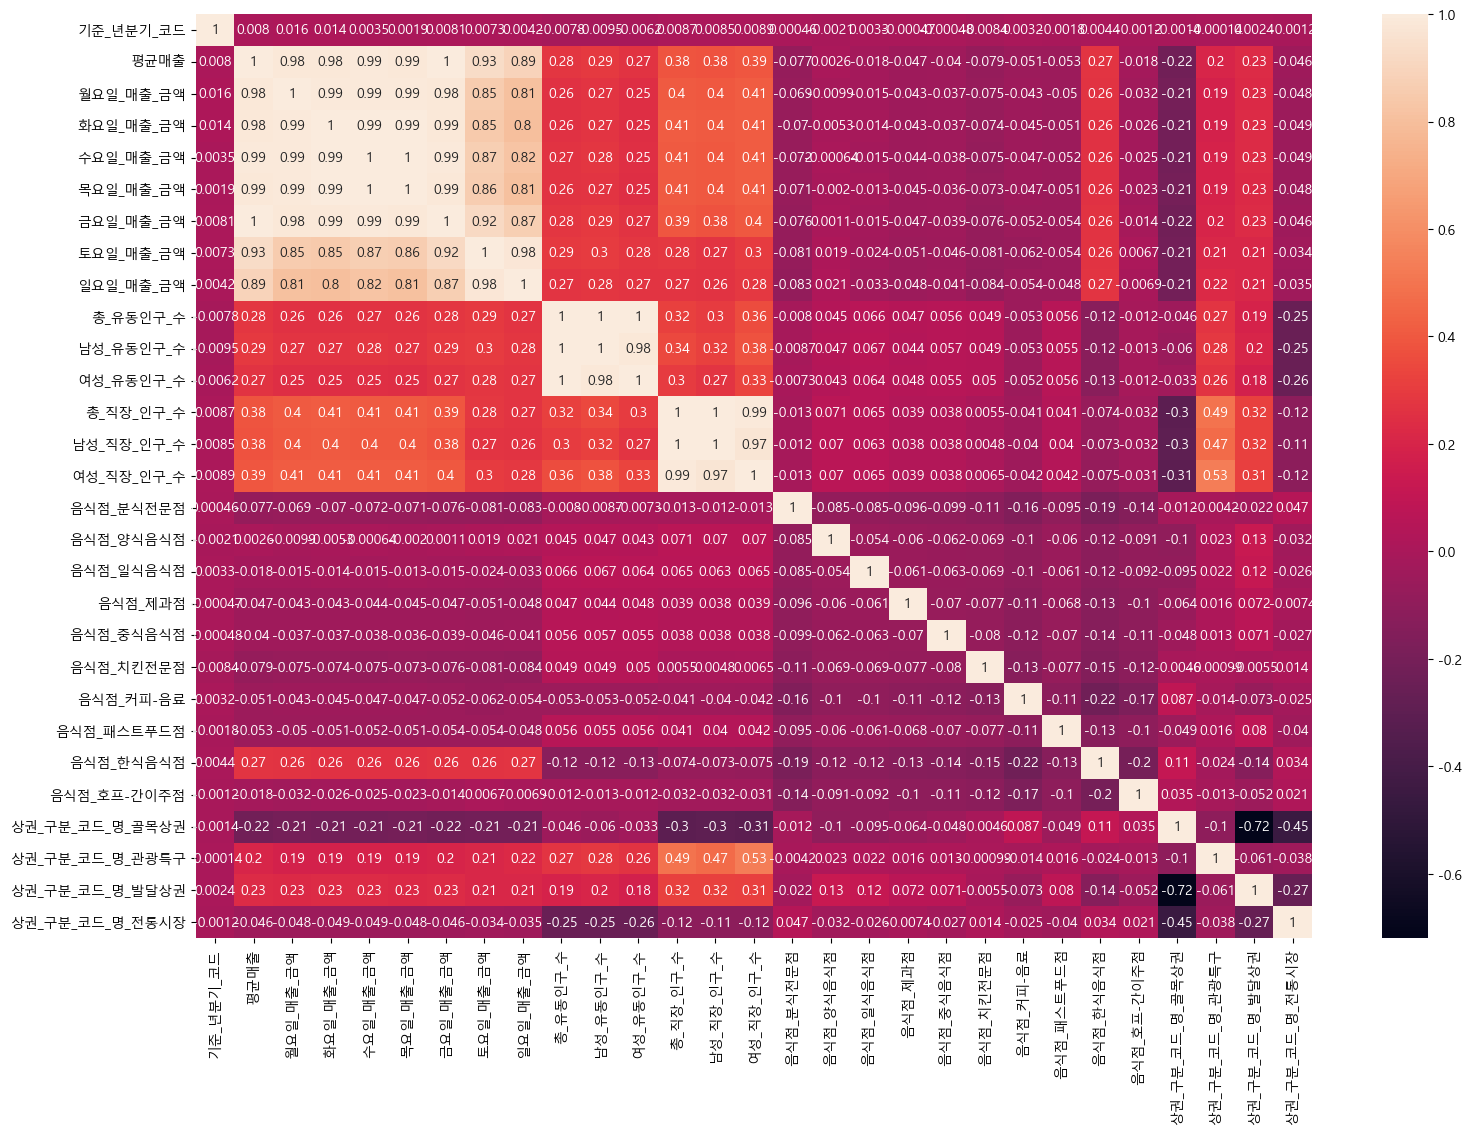

In [812]:
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [814]:
correlation_matrix = corr_matrix.corr()["평균매출"]
correlation_matrix_sorted = correlation_matrix.sort_values(ascending=False)
correlation_matrix_sorted

평균매출               1.000000
금요일_매출_금액          0.999914
수요일_매출_금액          0.998950
목요일_매출_금액          0.998623
월요일_매출_금액          0.998522
화요일_매출_금액          0.998331
토요일_매출_금액          0.991600
일요일_매출_금액          0.987408
음식점_한식음식점          0.570960
여성_직장_인구_수         0.520372
총_직장_인구_수          0.515125
남성_직장_인구_수         0.511353
상권_구분_코드_명_발달상권    0.443171
남성_유동인구_수          0.343260
상권_구분_코드_명_관광특구    0.335491
총_유동인구_수           0.327471
여성_유동인구_수          0.312141
음식점_양식음식점         -0.015304
음식점_호프-간이주점       -0.038923
음식점_일식음식점         -0.072184
상권_구분_코드_명_전통시장   -0.098735
음식점_커피-음료         -0.107897
음식점_중식음식점         -0.120202
기준_년분기_코드         -0.127868
음식점_제과점           -0.140411
음식점_패스트푸드점        -0.153622
음식점_분식전문점         -0.186947
음식점_치킨전문점         -0.217538
상권_구분_코드_명_골목상권   -0.401825
Name: 평균매출, dtype: float64

In [816]:
restaurants_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27006 entries, 0 to 27094
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        27006 non-null  int64  
 1   상권_코드_명          27006 non-null  object 
 2   평균매출             27006 non-null  float64
 3   월요일_매출_금액        27006 non-null  float64
 4   화요일_매출_금액        27006 non-null  float64
 5   수요일_매출_금액        27006 non-null  float64
 6   목요일_매출_금액        27006 non-null  float64
 7   금요일_매출_금액        27006 non-null  float64
 8   토요일_매출_금액        27006 non-null  float64
 9   일요일_매출_금액        27006 non-null  float64
 10  총_유동인구_수         27006 non-null  float64
 11  남성_유동인구_수        27006 non-null  float64
 12  여성_유동인구_수        27006 non-null  float64
 13  총_직장_인구_수        27006 non-null  float64
 14  남성_직장_인구_수       27006 non-null  float64
 15  여성_직장_인구_수       27006 non-null  float64
 16  음식점_분식전문점        27006 non-null  bool   
 17  음식점_양식음식점        

---

<Axes: xlabel='평균매출', ylabel='Count'>

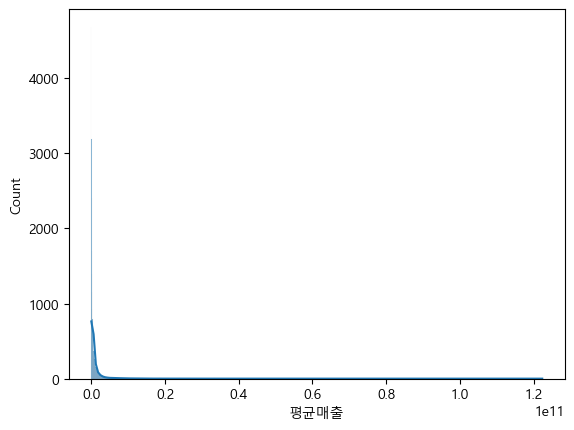

In [818]:
sns.histplot(restaurants_final["평균매출"], kde=True)

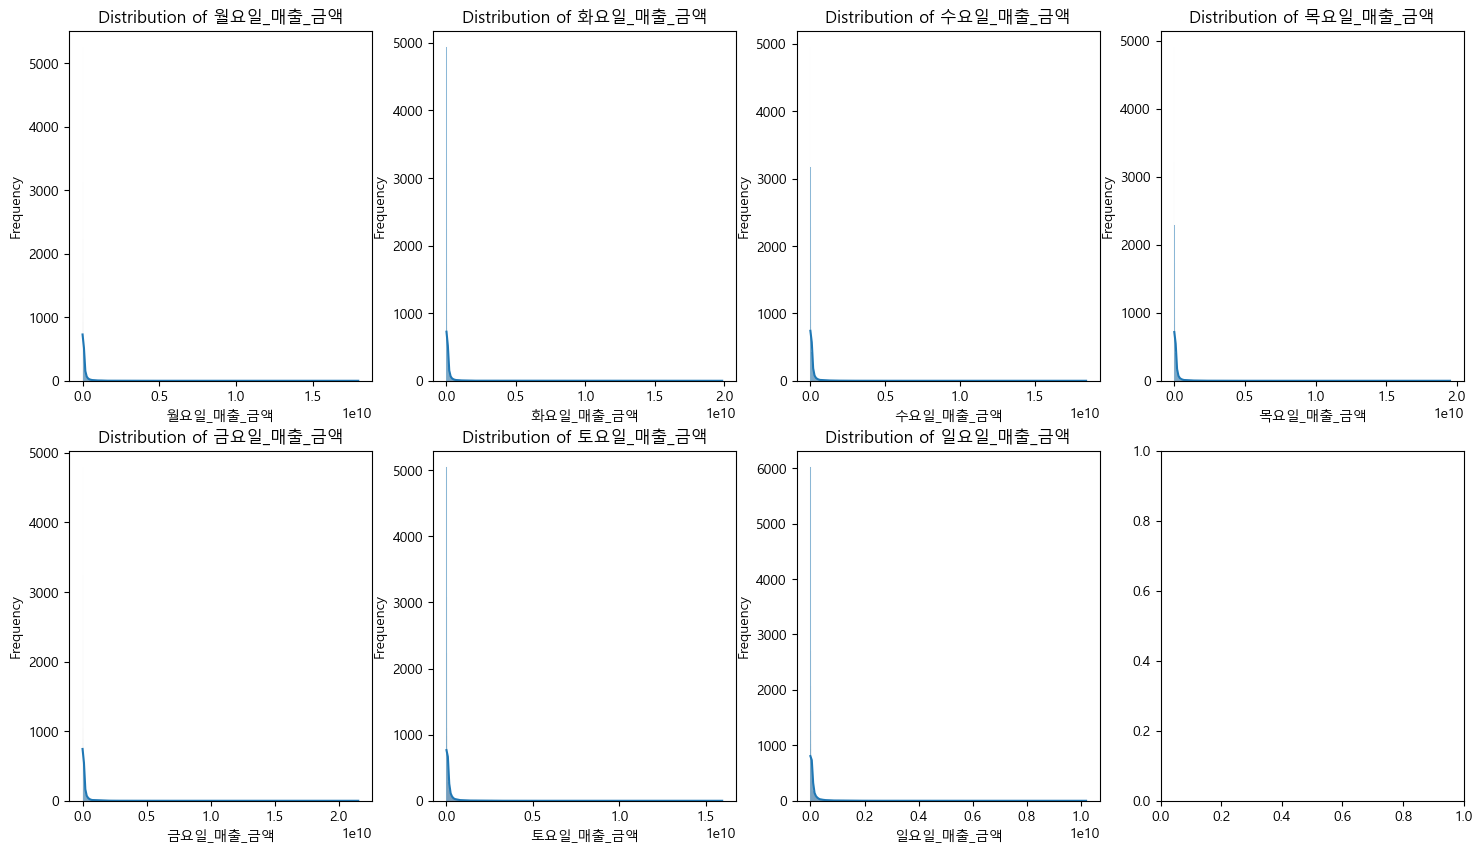

In [820]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))  # 2행 4열의 서브플롯 (총 8개의 서브플롯)

days_of_week = ["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액", 
                "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", 
                "일요일_매출_금액"]

for i, day in enumerate(days_of_week):
    row = i // 4
    col = i % 4
    
    sns.histplot(restaurants_final[day], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {day}")
    axes[row, col].set_xlabel(f"{day}")
    axes[row, col].set_ylabel("Frequency")

plt.show()

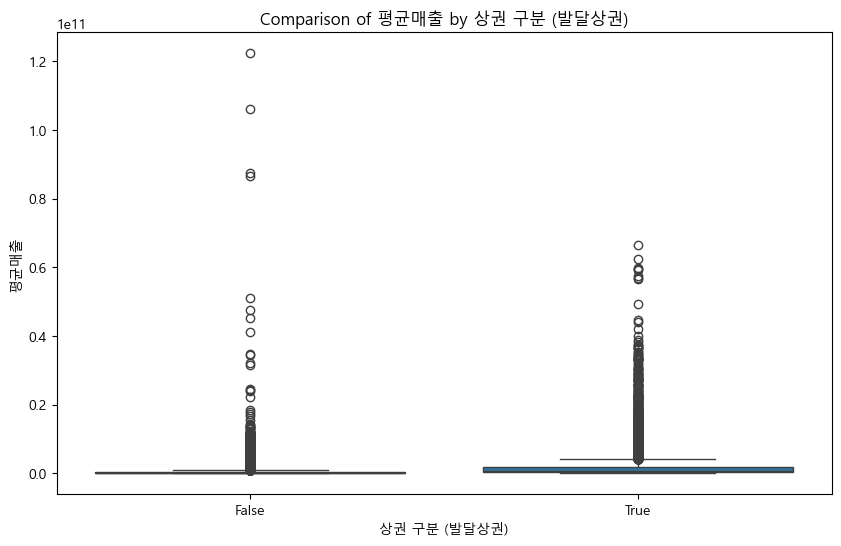

In [822]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="상권_구분_코드_명_발달상권", y="평균매출", data=restaurants_final)
plt.title("Comparison of 평균매출 by 상권 구분 (발달상권)")
plt.xlabel("상권 구분 (발달상권)")
plt.ylabel("평균매출")
plt.show()

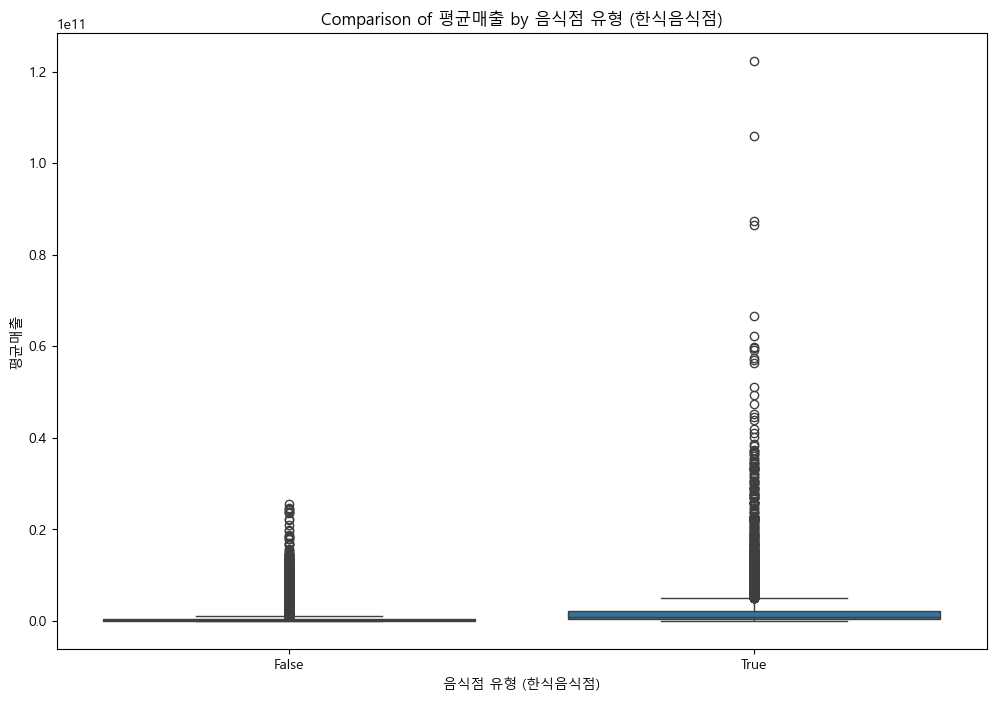

In [824]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="음식점_한식음식점", y="평균매출", data=restaurants_final)
plt.title("Comparison of 평균매출 by 음식점 유형 (한식음식점)")
plt.xlabel("음식점 유형 (한식음식점)")
plt.ylabel("평균매출")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 평균매출 분포
axes[0].set_title("Distribution of 평균매출")
axes[0].set_xlabel("평균매출")
axes[0].set_ylabel("Frequency")

# 월요일 매출 금액 분포
sns.histplot(restaurants_final["월요일_매출_금액"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of 월요일_매출_금액")
axes[1].set_xlabel("월요일_매출_금액")
axes[1].set_ylabel("Frequency")

# 금요일 매출 금액 분포
sns.histplot(restaurants_final["금요일_매출_금액"], kde=True, ax=axes[2])
axes[2].set_title("Distribution of 금요일_매출_금액")
axes[2].set_xlabel("금요일_매출_금액")
axes[2].set_ylabel("Frequency")

# 레이아웃 정리
plt.tight_layout()
plt.show()

X=서비스업종명, 유동인구수,   
Y=당월 매출금액  
훈련 -> 예측  

업종마다의 금액이 나오니까  

X=상권구분, 서비스업종명, 유동인구수  
Y=당월 매출금액  